In [1]:
from tidyverse.dummy import *
import scanpy as sc
plt.rcParams["figure.figsize"] = (4,3)

import decoupler as dc
from matplotlib_inline.backend_inline import set_matplotlib_formats
from ecm_de_data import load_ECM_M_vs_T, load_ECM_NE_vs_M, load_ECM_NE_vs_T, cmap_updown

plt.ion()

import sys
sys.path.append('..')
from util import load_merged_data
from colormaps import color_dict_coarse_celltype, color_dict_diagnosis


Importing tidyverse


In [2]:
plotfolder = '/tmp/ECM_M_vs_T'
import os
if not os.path.exists(plotfolder):
    os.mkdir(plotfolder)

In [3]:
import gc
gc.collect()

20

In [4]:
df_M_vs_T  = load_ECM_M_vs_T()
df_M_vs_T['Pvalue_clipped'] = np.clip(df_M_vs_T['Pvalue'] , 1e-30,  1)
df_M_vs_T.shape

(2599, 8)

# Volcano plots

/tmp/ipykernel_195444/855049721.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


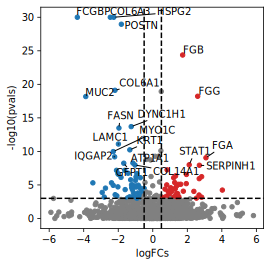

/tmp/ipykernel_195444/855049721.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


In [5]:
set_matplotlib_formats('svg')
dc.plot_volcano_df(
    df_M_vs_T.set_index('gene'), x='log2fc', y='Pvalue_clipped',
    sign_thr=0.001, lFCs_limit=6,
    top=20,
    figsize=(4,4), save=f'{plotfolder}/volcano.svg')
plt.show()
set_matplotlib_formats('png')

/tmp/ipykernel_195444/290456511.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


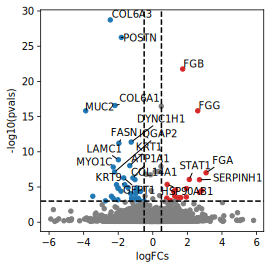

/tmp/ipykernel_195444/290456511.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


In [6]:
set_matplotlib_formats('svg')
dc.plot_volcano_df(
    df_M_vs_T.set_index('gene'), x='log2fc', y='qvalue',
    sign_thr=0.001, lFCs_limit=6,
    top=20,
    sign_limit=29,
    figsize=(4,4), save=f'{plotfolder}/volcano_qval.svg')
plt.show()
set_matplotlib_formats('png')

# sc

In [7]:
genes_up = sorted(df_M_vs_T.query('qvalue<0.001 and log2fc>0.58').gene.values)
genes_down = sorted(df_M_vs_T.query('qvalue<0.001 and log2fc<-0.58').gene.values)

In [8]:
len(genes_up),len(genes_down)

(18, 38)

In [9]:
" ".join(genes_up)

'ACTG1 ATP5F1B CNN2 CORO1A FBL FGA FGB FGG HSP90AB1 HSPA9 IGKC KRT18 PKM SAMHD1 SERPINH1 SQOR STAT1 XRCC6'

In [10]:
" ".join(genes_down)

'AOC3 APCS ATP1A1 C3 CKMT1A COL14A1 COL6A1 COL6A2 COL6A3 CPS1 CTNNA1 DYNC1H1 FASN FBN1 FCGBP FLNB GFPT1 HPGD HSPG2 IQGAP1 IQGAP2 KRT1 KRT2 KRT9 LAMA5 LAMB1 LAMB2 LAMC1 LGALS4 MUC2 MYO1A MYO1C MYO1D PAPSS2 PKP3 POSTN SERPINB5 TGFBI'

In [11]:
ECM_diagnosis = ["M", "T"]

/tmp/ipykernel_195444/2633978143.py:4: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.


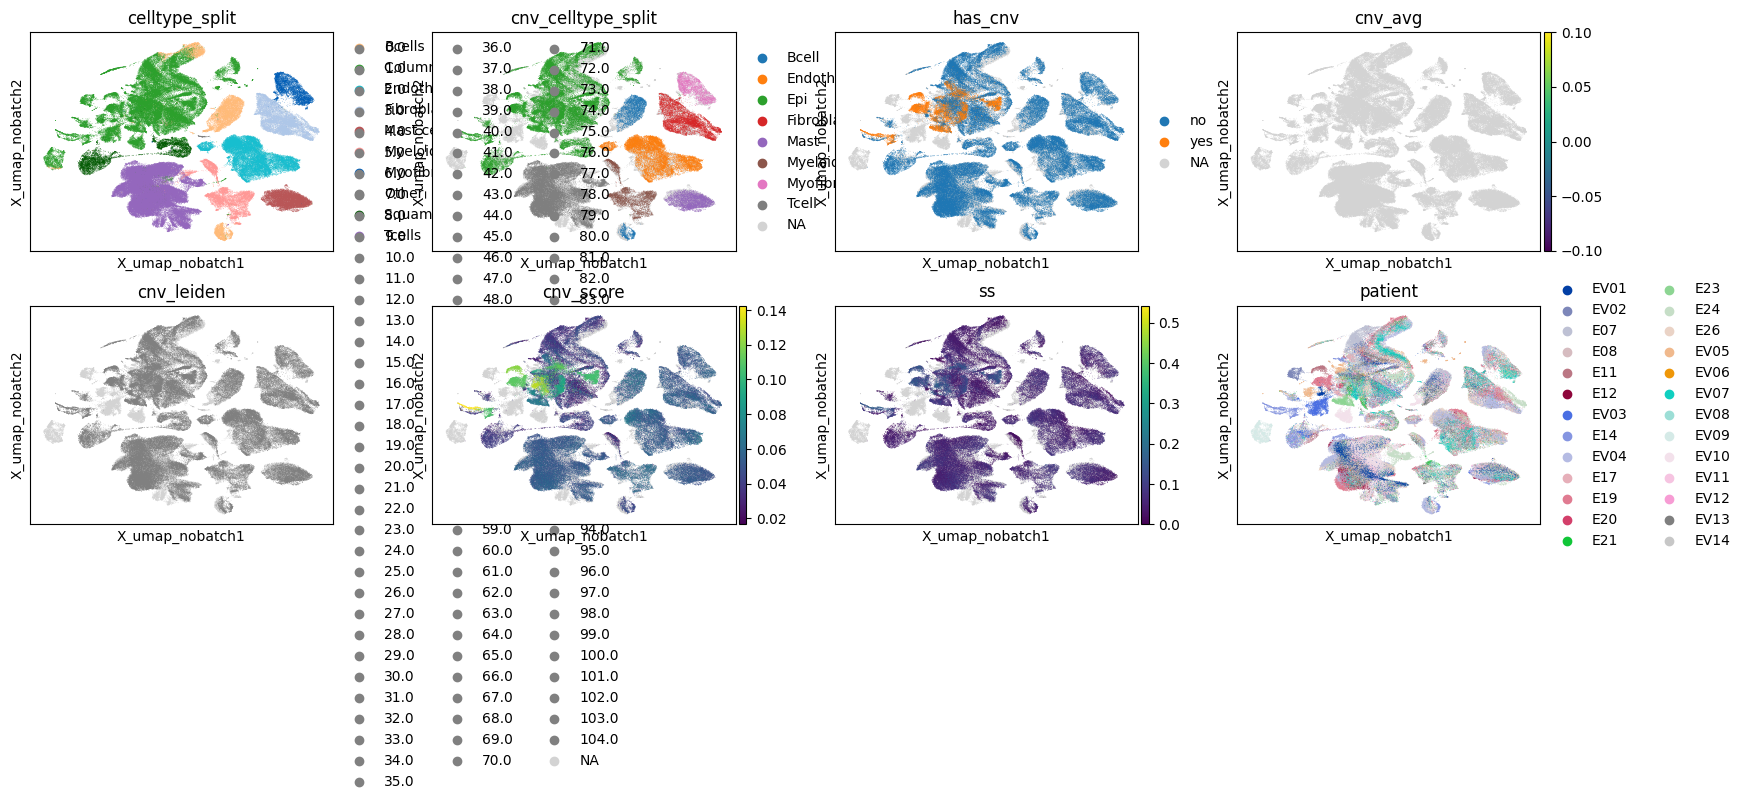

In [12]:
A = load_merged_data()

# add CNV calls
df_cnv = pd.read_csv('../Fig4/full_obs.csv.gz', index_col=0)
A.obs.index = A.obs.index.map(lambda x: '-'.join(x.split('-')[:2]))
A.obs = A.obs.merge(df_cnv[['cnv_celltype_split','has_cnv','cnv_avg','cnv_leiden', 'cnv_score', 'ss']], left_index=True, right_index=True, how='left')
A.obs.cnv_leiden = pd.Categorical(A.obs.cnv_leiden)

sc.pl.embedding(A, basis='X_umap_nobatch', color=['celltype_split', 'cnv_celltype_split', 'has_cnv','cnv_avg','cnv_leiden', 'cnv_score', 'ss', 'patient'])

In [13]:
ECM_patients = ["EV02","E14","E20", "E21","E24"]

In [14]:
A = A[A.obs.patient.isin(ECM_patients)]
A = A[A.obs.diagnosis.isin(ECM_diagnosis)].copy()
A.raw = A

In [15]:
cluster_order = [
    'Columnar Epithelium', 
    'Squamous Epithelium',
    'Bcells', 
    'Tcells',
    'Mast cells', 
    'Myeloid',
    'Endothelial cells', 
    'Fibroblasts',
    'Myofibroblasts',
    'Other',
]

A.obs.celltype_split = pd.Categorical(A.obs.celltype_split, cluster_order)

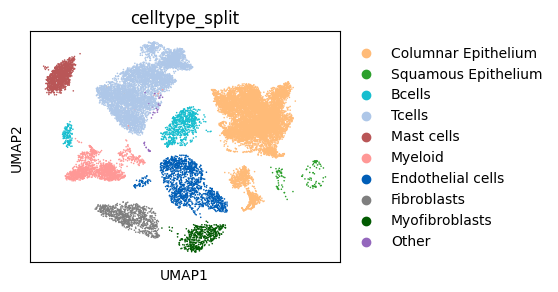

In [16]:
sc.pl.umap(A, color='celltype_split')

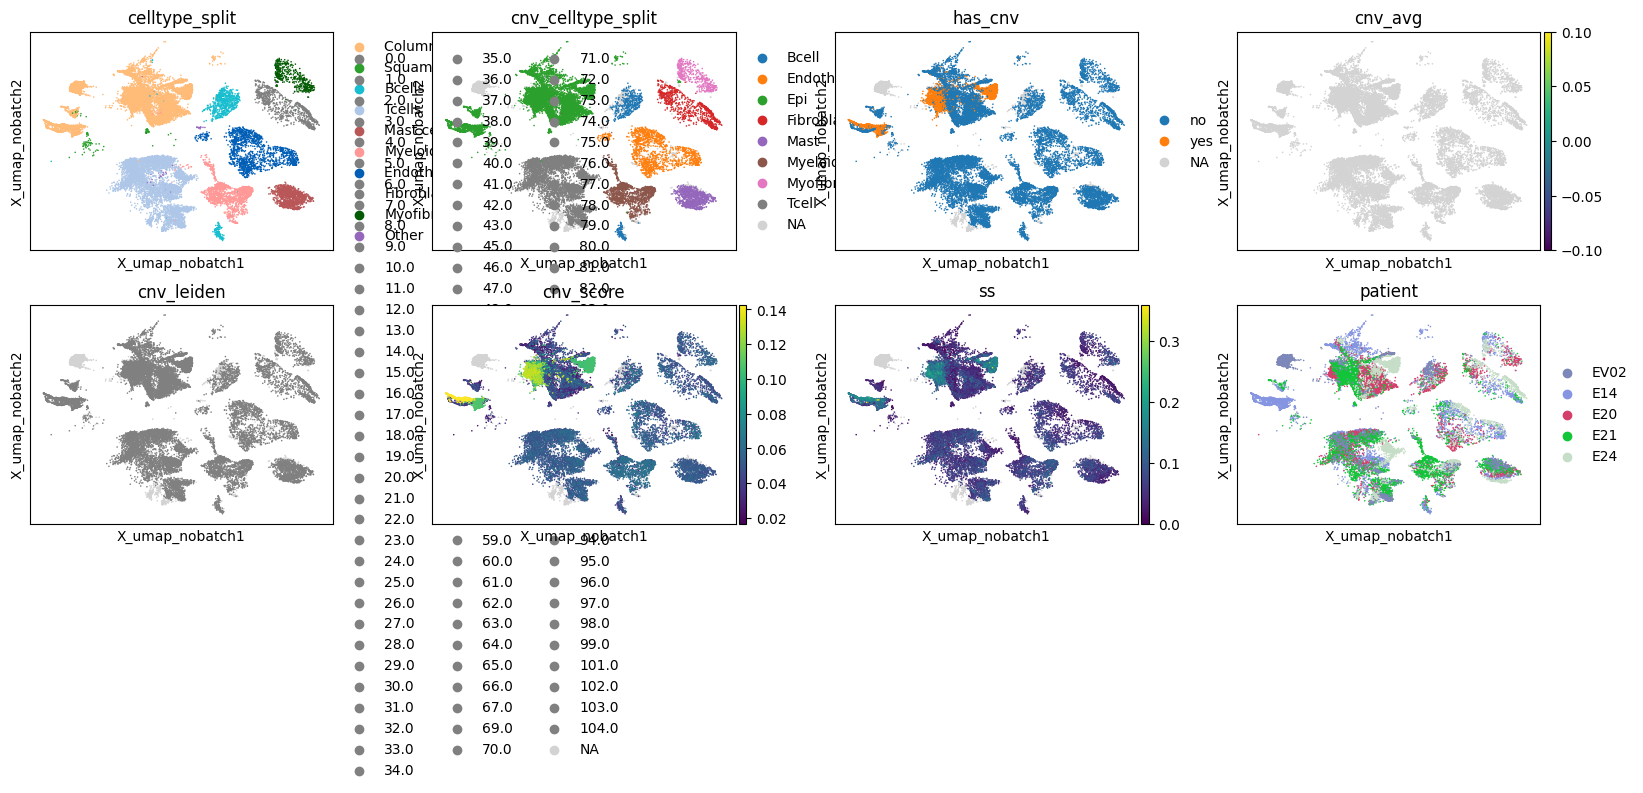

In [17]:
sc.pl.embedding(A, basis='X_umap_nobatch', color=['celltype_split', 'cnv_celltype_split', 'has_cnv','cnv_avg','cnv_leiden', 'cnv_score', 'ss', 'patient'])

In [18]:
A.obs['celltype_split_cnv_augmented'] = A.obs['celltype_split'].astype(str)
A.obs.loc[A.obs.query('celltype_split=="Columnar Epithelium" and has_cnv=="yes"').index, 'celltype_split_cnv_augmented'] = "Columnar Epithelium (CNV+)"
A.obs.loc[A.obs.query('celltype_split=="Columnar Epithelium" and has_cnv=="no"').index, 'celltype_split_cnv_augmented'] = "Columnar Epithelium (CNV-)"

_c = ['Columnar Epithelium (CNV-)', 'Columnar Epithelium (CNV+)', 'Squamous Epithelium', 'Bcells', 'Tcells', 'Mast cells', 'Myeloid', 'Endothelial cells', 'Fibroblasts',  'Myofibroblasts', 'Other']
A.obs.celltype_split_cnv_augmented = pd.Categorical(A.obs.celltype_split_cnv_augmented, _c) 

pd.crosstab(A.obs.celltype_split_cnv_augmented, A.obs.has_cnv)

has_cnv                         no   yes
celltype_split_cnv_augmented            
Columnar Epithelium (CNV-)    5500     0
Columnar Epithelium (CNV+)       0  4095
Squamous Epithelium             99     0
Bcells                         547     0
Tcells                        4706     0
Mast cells                    1037     0
Myeloid                       1478     0
Endothelial cells             1364     0
Fibroblasts                    833     0
Myofibroblasts                 449     0
Other                           30     0

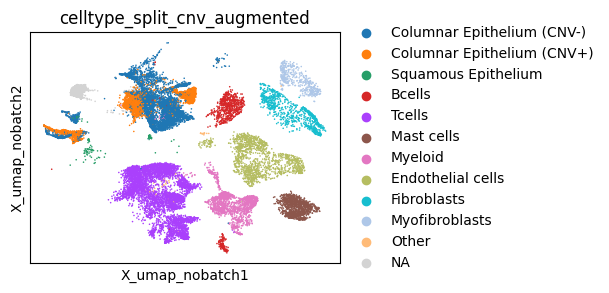

In [19]:
sc.pl.embedding(A, basis='X_umap_nobatch', color=['celltype_split_cnv_augmented'])

# M vs T differential expression

## ECM-DE vs cell types

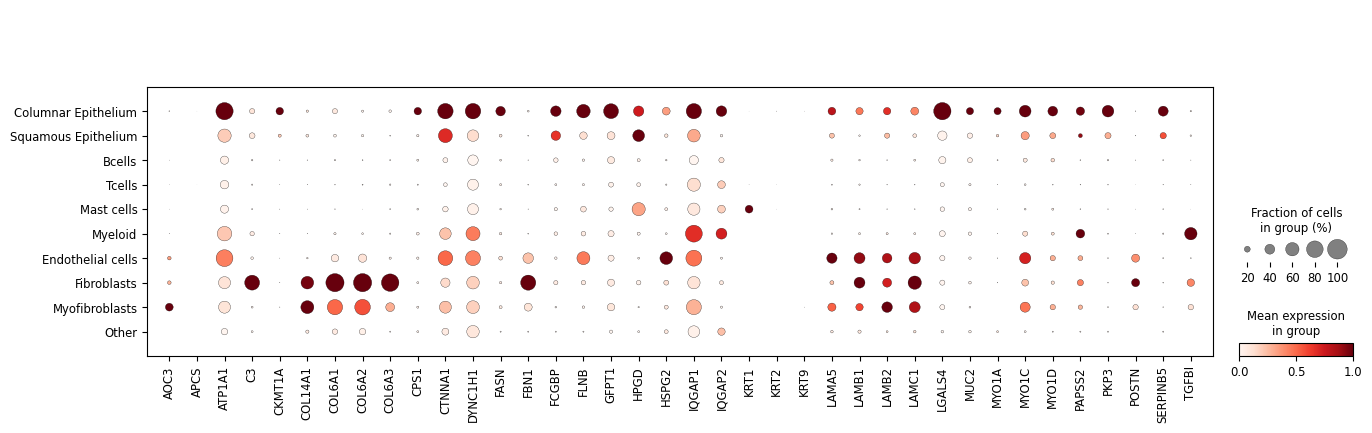

In [20]:
sc.pl.dotplot(A, var_names=genes_down, groupby='celltype_split', standard_scale='var', dendrogram=False, show=False)
plt.savefig(f'{plotfolder}/ECM_singlecellsource_downreg.svg')

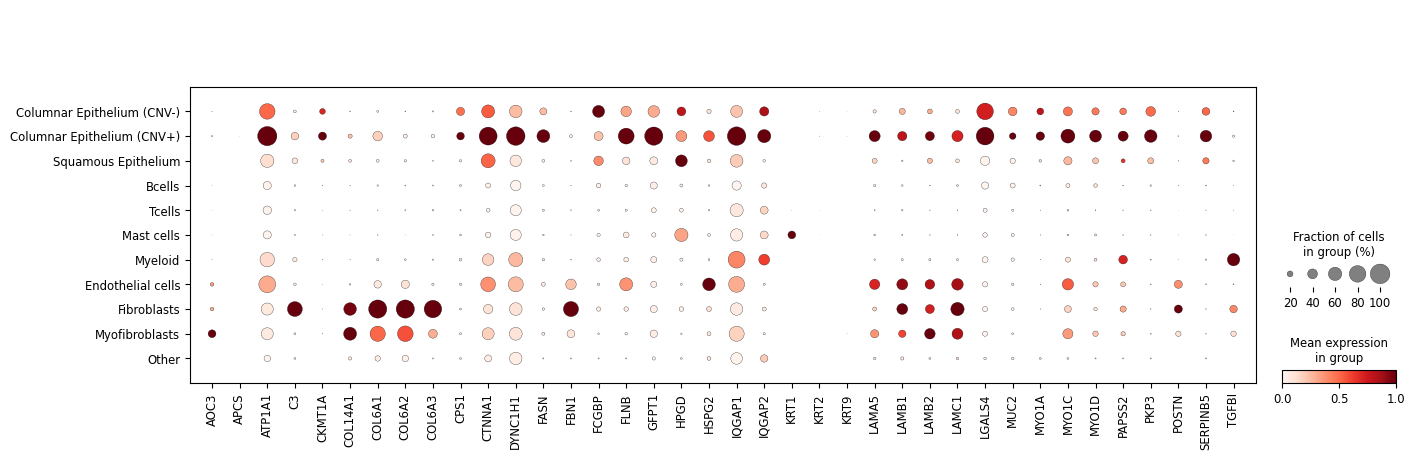

In [21]:
sc.pl.dotplot(A, var_names=genes_down, groupby='celltype_split_cnv_augmented', standard_scale='var', dendrogram=False, show=False)
plt.savefig(f'{plotfolder}/ECM_singlecellsource_downreg.svg')

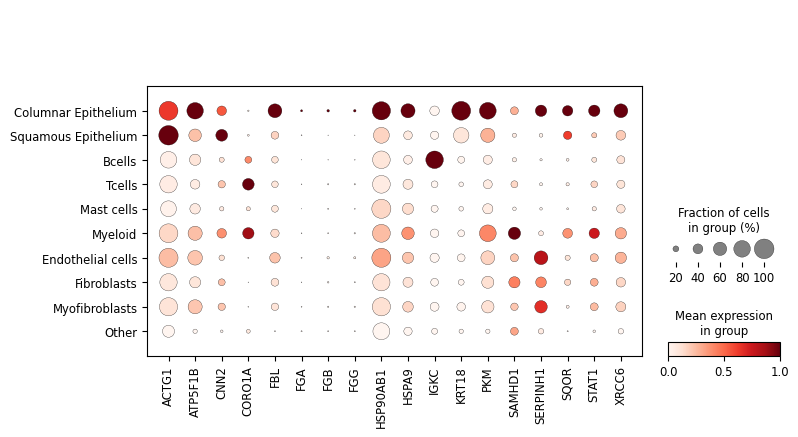

In [22]:
sc.pl.dotplot(A, var_names=genes_up, groupby='celltype_split', standard_scale='var', dendrogram=False, show=False)
plt.savefig(f'{plotfolder}/ECM_singlecellsource_upreg.svg')

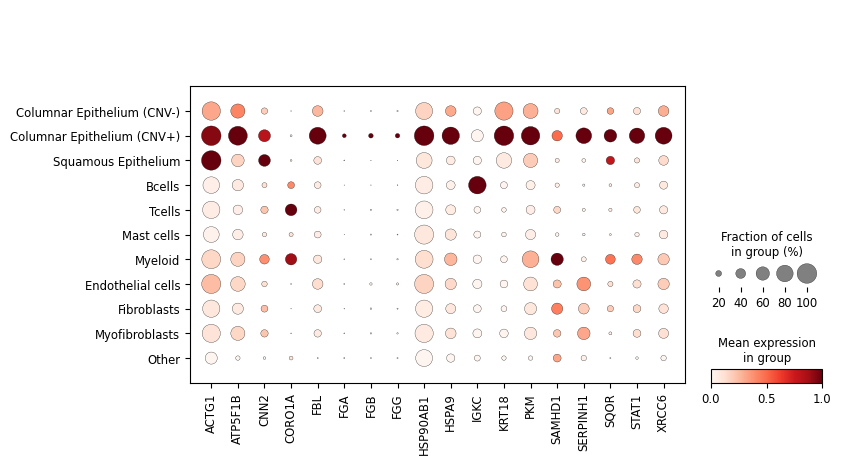

In [23]:
sc.pl.dotplot(A, var_names=genes_up, groupby='celltype_split_cnv_augmented', standard_scale='var', dendrogram=False, show=False)
plt.savefig(f'{plotfolder}/ECM_singlecellsource_upreg.svg')

In [24]:
_d = A.obs.groupby(['celltype_split_cnv_augmented','diagnosis']).samplename.count().reset_index().rename({'samplename': 'n_cells'}, axis=1)
celltype_total = _d .groupby('celltype_split_cnv_augmented').n_cells.sum().to_dict()
_d['total'] = _d.celltype_split_cnv_augmented.apply(lambda x: celltype_total[x]).astype(int)
_d['percent_cells'] = _d.n_cells / _d.total
# reverse order so it works in the flipped diagram
_d['celltype_split_cnv_augmented'] = pd.Categorical(_d['celltype_split_cnv_augmented'] , _d['celltype_split_cnv_augmented'].cat.categories[::-1])
_d.head()

/tmp/ipykernel_195444/1318121404.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_195444/1318121404.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


celltype_split_cnv_augmented diagnosis  n_cells  total  percent_cells
0   Columnar Epithelium (CNV-)         M     4165   5500       0.757273
1   Columnar Epithelium (CNV-)         T     1335   5500       0.242727
2   Columnar Epithelium (CNV+)         M      432   4095       0.105495
3   Columnar Epithelium (CNV+)         T     3663   4095       0.894505
4          Squamous Epithelium         M       83    118       0.703390

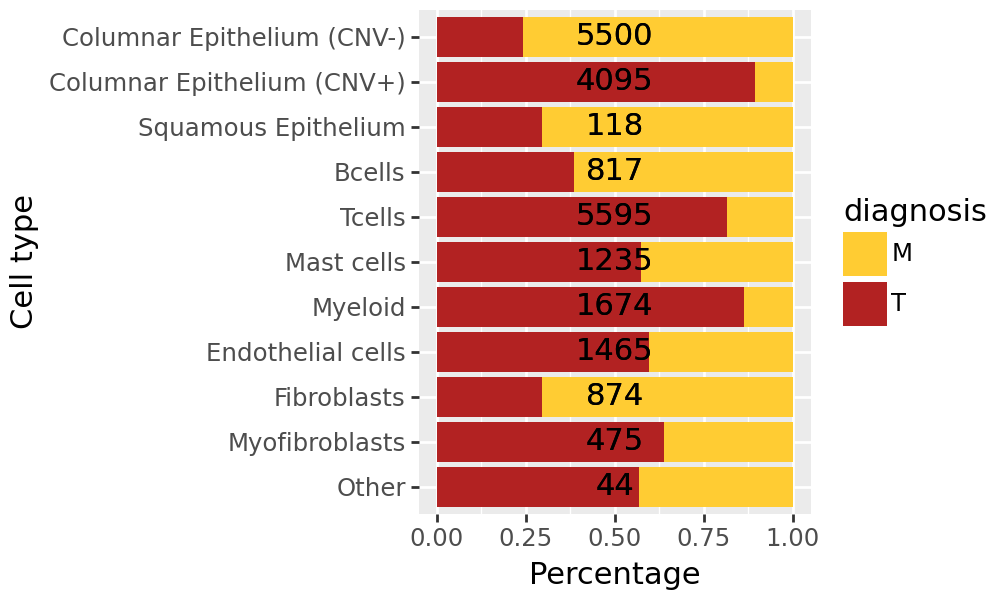

In [25]:
pn.ggplot(_d) +pn.aes(x='celltype_split_cnv_augmented', fill='diagnosis', y='percent_cells') + pn.geom_bar(stat='identity') \
+ pn.geom_text(data=_d, mapping=pn.aes( x='celltype_split_cnv_augmented', y=0.5, label='total')) \
+ pn.coord_flip()+pn.theme(figure_size=(5,3)) + pn.labs(y='Percentage', x='Cell type') + pn.scale_fill_manual(color_dict_diagnosis)

# General fold change in proteomics vs scrnaseq 
## Naive foldchanges in scRNAseq
independent of cell type etc

In [26]:
from ecm_tools import fold_change_pseudobulk_fixed
import decoupler as dc

adata_bulk_de = dc.get_pseudobulk(
        A,
        sample_col='samplename', 
        groups_col=None,
        use_raw=False,
        mode='sum',
        min_cells=0,
        # min_counts=10000,
    )
adata_bulk_de.raw  = adata_bulk_de

In [27]:
_FC_pseudobulk_df =  fold_change_pseudobulk_fixed(adata_bulk_de, gene_list=genes_up+genes_down, diagnosis1="M", diagnosis2="T")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 189.03it/s]


/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_M_vs_T/ECM_FC_comparison.svg


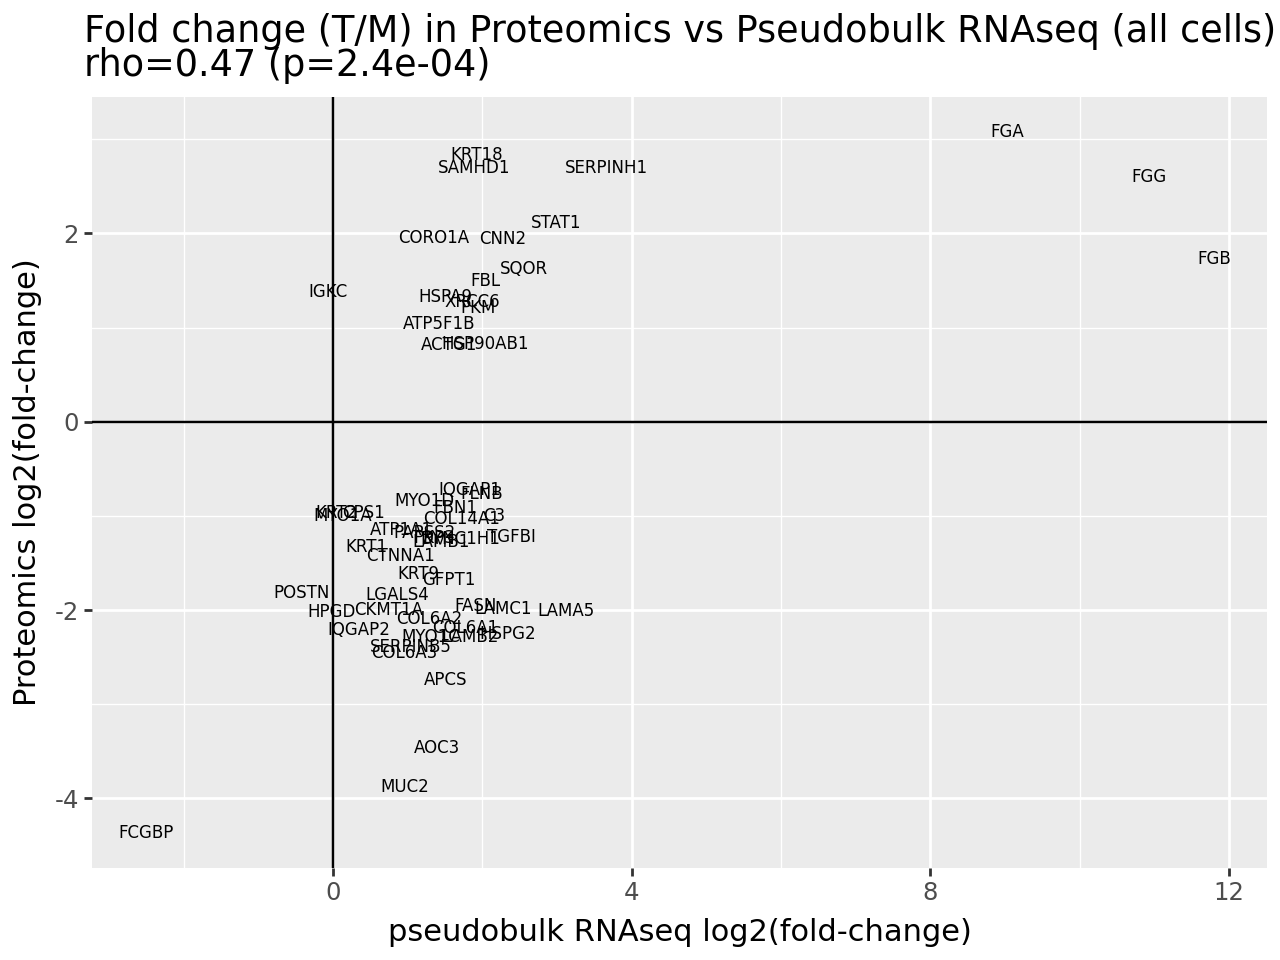

In [28]:
df_FC_sc_proteomics = _FC_pseudobulk_df\
 .merge(df_M_vs_T.rename({'log2fc': 'log2fc_proteomics', 'qvalue': 'qvalue_proteomics'}, axis=1), on='gene')#\

from scipy.stats import spearmanr
rho, pval_rho = spearmanr(
    np.log2(df_FC_sc_proteomics.ratio_scrnaseq),
    df_FC_sc_proteomics.log2fc_proteomics)

p = (
    pn.ggplot(df_FC_sc_proteomics)
    + pn.aes('np.log2(ratio_scrnaseq)', 'log2fc_proteomics', label='gene' )
    + pn.geom_text(size=6) 
    + pn.geom_vline(xintercept=0) 
    + pn.geom_hline(yintercept=0)
    + pn.labs(title=f'Fold change (T/M) in Proteomics vs Pseudobulk RNAseq (all cells)\nrho={rho:.2f} (p={pval_rho:.1e})', x='pseudobulk RNAseq log2(fold-change)', y='Proteomics log2(fold-change)')
)
p.save(f'{plotfolder}/ECM_FC_comparison.svg')
p

## Using Deseq to get FCs

In [29]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import decoupler as dc

In [30]:
pdata = dc.get_pseudobulk(A.raw.to_adata(),
                          sample_col='samplename',
                          groups_col='diagnosis',#'celltype_split',
                          mode='sum',
                          min_cells=50,
                         )
pdata

AnnData object with n_obs × n_vars = 13 × 29954
    obs: 'samplename', 'diagnosis', 'patient', 'procedure', 'dataset', 'psbulk_n_cells', 'psbulk_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'is_mito', 'is_ribo', 'old_genename'
    layers: 'psbulk_props'

### Actual DE
#### With patient

In [31]:
dds = DeseqDataSet(
    adata=pdata.copy(),
    design_factors=['patient','diagnosis'],
    refit_cooks=True,
    n_cpus=8,
)
dds.deseq2()

stats_res = DeseqStats(dds, contrast=["diagnosis",  "T", "M"])
stats_res.summary()
# stats_res.lfc_shrink(coeff='diagnosis_T_vs_M')
df_DE= stats_res.results_df


stats_res = DeseqStats(dds, contrast=["diagnosis",  "T", "M"])
stats_res.summary()
stats_res.lfc_shrink(coeff='diagnosis_T_vs_M')
df_DE_shrink= stats_res.results_df

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 6.72 seconds.

Fitting dispersion trend curve...
... done in 1.58 seconds.

Fitting MAP dispersions...
... done in 9.83 seconds.

Fitting LFCs...
... done in 7.65 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 9.97 seconds.



Log2 fold change & Wald test p-value: diagnosis T vs M
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG     438.462276        0.042596  0.303848  0.140187  0.888512  0.959417
A1CF     425.248355       -2.396091  0.665110 -3.602549  0.000315  0.007477
A2M     2336.899094       -0.167449  0.405041 -0.413413  0.679304  0.865651
A2ML1    117.363236        0.154701  0.307434  0.503202  0.614822  0.831453
A2MP1     13.290074       -0.183477  0.619146 -0.296339  0.766971  0.908073
...             ...             ...       ...       ...       ...       ...
ZYG11A    59.378019        0.221365  0.186284  1.188321  0.234707  0.532071
ZYG11B   599.340718       -0.031835  0.100192 -0.317743  0.750680  0.901747
ZYX     1048.430092        0.070595  0.248748  0.283799  0.776564  0.913142
ZZEF1    527.037322       -0.755401  0.230926 -3.271187  0.001071  0.018195
ZZZ3     460.671893       -0.034707  0.188085 -0.184527  0.853600  0.945648

[29954 rows x 6 columns]


Running Wald tests...
... done in 2.47 seconds.



Log2 fold change & Wald test p-value: diagnosis T vs M
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG     438.462276        0.042596  0.303848  0.140187  0.888512  0.959417
A1CF     425.248355       -2.396091  0.665110 -3.602549  0.000315  0.007477
A2M     2336.899094       -0.167449  0.405041 -0.413413  0.679304  0.865651
A2ML1    117.363236        0.154701  0.307434  0.503202  0.614822  0.831453
A2MP1     13.290074       -0.183477  0.619146 -0.296339  0.766971  0.908073
...             ...             ...       ...       ...       ...       ...
ZYG11A    59.378019        0.221365  0.186284  1.188321  0.234707  0.532071
ZYG11B   599.340718       -0.031835  0.100192 -0.317743  0.750680  0.901747
ZYX     1048.430092        0.070595  0.248748  0.283799  0.776564  0.913142
ZZEF1    527.037322       -0.755401  0.230926 -3.271187  0.001071  0.018195
ZZZ3     460.671893       -0.034707  0.188085 -0.184527  0.853600  0.945648

[29954 rows x 6 columns]


Fitting MAP LFCs...
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))


Shrunk log2 fold change & Wald test p-value: diagnosis T vs M
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG     438.462276        0.016263  0.175403  0.140187  0.888512  0.959417
A1CF     425.248355       -0.316870  0.546563 -3.602549  0.000315  0.007477
A2M     2336.899094       -0.053459  0.222617 -0.413413  0.679304  0.865651
A2ML1    117.363236        0.059681  0.423070  0.503202  0.614822  0.831453
A2MP1     13.290074       -0.021310  0.240792 -0.296339  0.766971  0.908073
...             ...             ...       ...       ...       ...       ...
ZYG11A    59.378019        0.148946  0.173272  1.188321  0.234707  0.532071
ZYG11B   599.340718       -0.026503  0.095496 -0.317743  0.750680  0.901747
ZYX     1048.430092        0.035355  0.231492  0.283799  0.776564  0.913142
ZZEF1    527.037322       -0.612115  0.259183 -3.271187  0.001071  0.018195
ZZZ3     460.671893       -0.022143  0.165690 -0.184527  0.853600  0.945648

[29954 rows x 6 columns]


... done in 6.84 seconds.



### Plots

In [32]:
from ecm_tools import plot_fc_comparision

#### patient + diag, unshrubk

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_M_vs_T/ECM_FC_comparison_unshrunk_patient_diag.svg


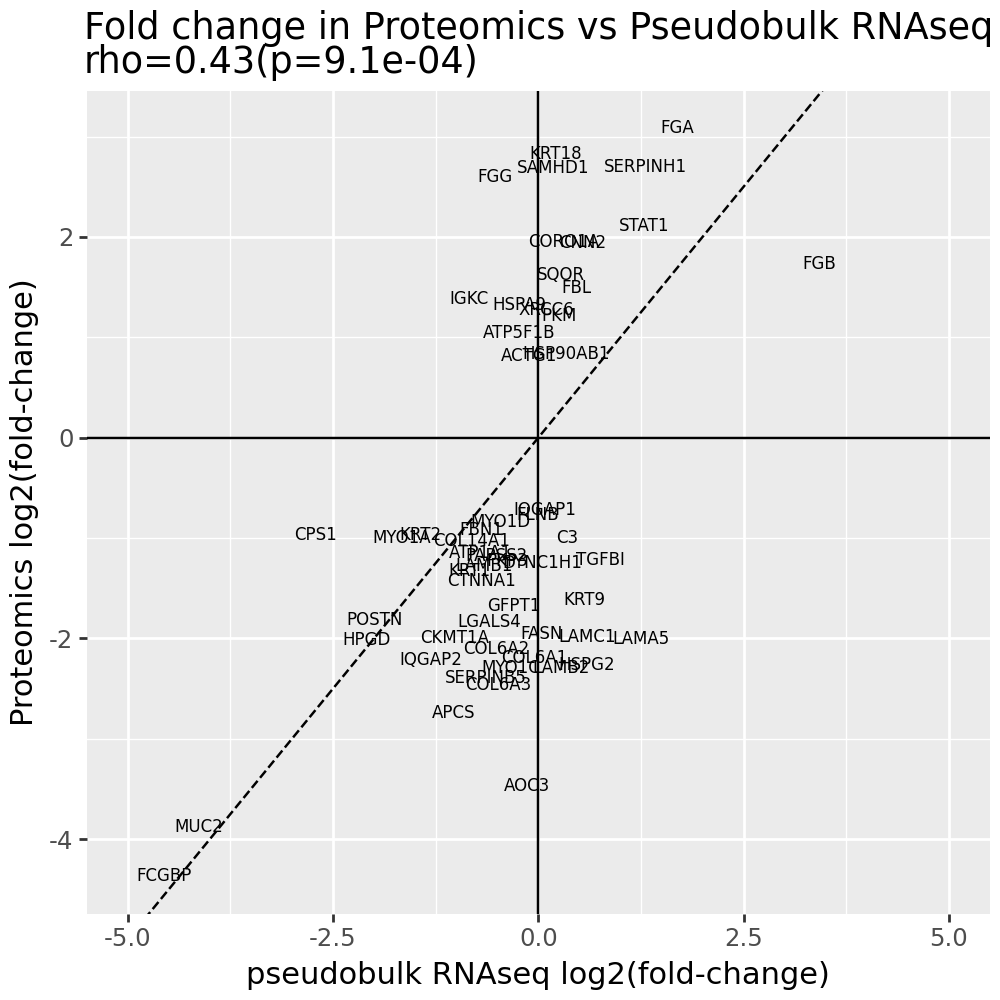

In [33]:
df = df_DE.merge(df_M_vs_T.set_index('gene'), left_index=True, right_index=True).loc[genes_up+genes_down]#.query('padj<0.1')
p = plot_fc_comparision(df, ) + pn.theme(figure_size=(5,5))
p.save(f'{plotfolder}/ECM_FC_comparison_unshrunk_patient_diag.svg')
p

#### patient + diag, with shrinkage

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_M_vs_T/ECM_FC_comparison_shrunk_patient_diag.svg


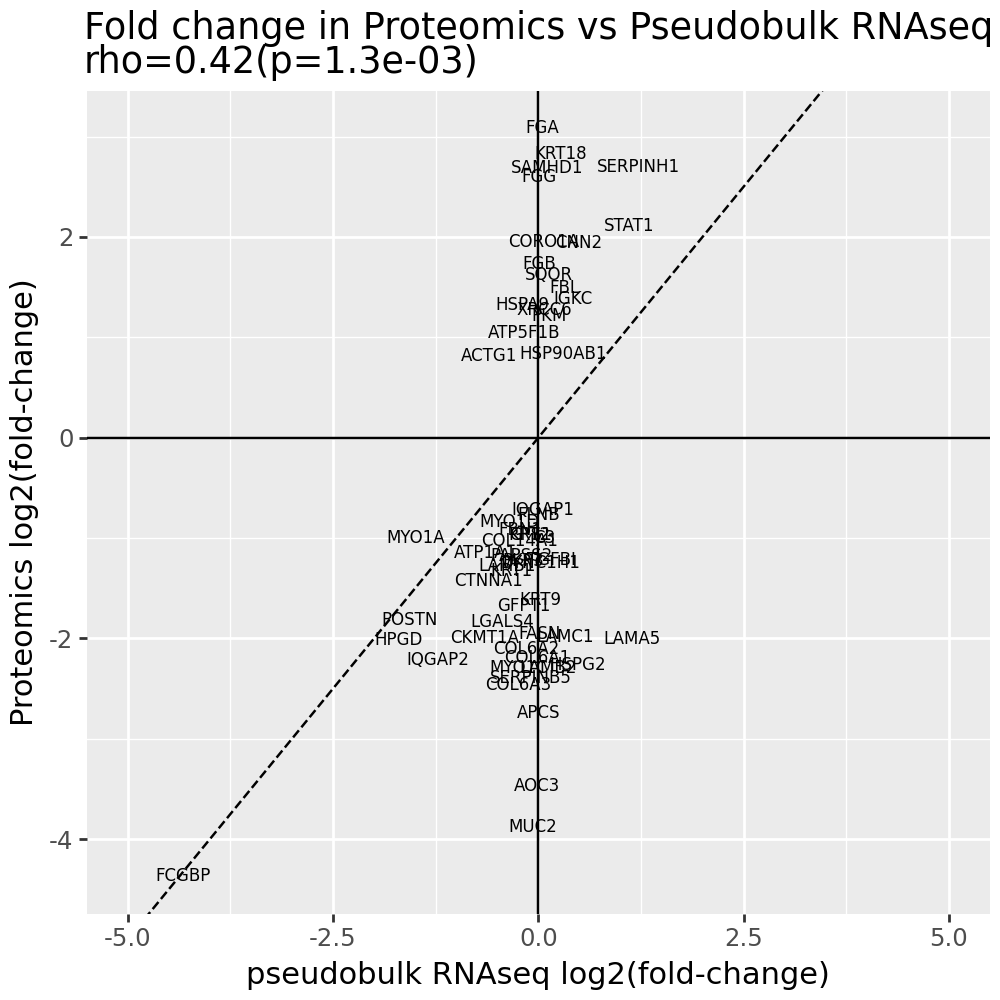

In [34]:
df = df_DE_shrink.merge(df_M_vs_T.set_index('gene'), left_index=True, right_index=True).loc[genes_up+genes_down]
p = plot_fc_comparision(df)+ pn.theme(figure_size=(5,5))
p.save(f'{plotfolder}/ECM_FC_comparison_shrunk_patient_diag.svg')
p

# Fold change by cell type

In [35]:
colormap = pn.scale_color_manual(color_dict_coarse_celltype)
theme =  pn.theme(figure_size=(5,9), panel_background=pn.element_rect(fill='white', alpha=.2), line=pn.element_line(color='grey'))

In [36]:
from ecm_tools import suis_plot_fixed, ecm_lfc_via_deseq_python

In [37]:
from ecm_tools import ecm_lfc_via_deseq_python, the_plot_shrunk, the_plot_unshrunk

## DEseq fold changes

In [38]:
A.obs['celltype_merge_epi']=A.obs['celltype_split'].astype(str)
A.obs['celltype_merge_epi'].replace({'Columnar Epithelium': 'Epithelium','Squamous Epithelium': "Epithelium"}, inplace=True)

### ~patient + diagnosis

In [39]:
contrast = ["diagnosis",  "M", "T"]
design_factors = ['patient','diagnosis']
df_de_all, adata_vsds =  ecm_lfc_via_deseq_python(A, design_factors, contrast=contrast, gene_min_counts=10)
df_de_all['independent_filter'] = df_de_all.padj.apply(lambda x: 'filtered' if np.isnan(x) else 'ok')

Celltype: Tcells


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.62 seconds.

Fitting dispersion trend curve...
... done in 0.68 seconds.

Fitting MAP dispersions...
... done in 3.00 seconds.

Fitting LFCs...
... done in 3.59 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.



Fit type used for VST : parametric


Fitting dispersions...
... done in 1.85 seconds.



Celltype: Epithelium


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.44 seconds.

Fitting dispersion trend curve...
... done in 0.78 seconds.

Fitting MAP dispersions...
... done in 4.89 seconds.

Fitting LFCs...
... done in 4.82 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.



Fit type used for VST : parametric


Fitting dispersions...
... done in 2.89 seconds.



Celltype: Mast cells


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.82 seconds.

Fitting dispersion trend curve...
... done in 0.77 seconds.

Fitting MAP dispersions...
... done in 2.76 seconds.

Fitting LFCs...
... done in 4.00 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



Fit type used for VST : parametric


Fitting dispersions...
... done in 1.49 seconds.



Celltype: Fibroblasts


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.07 seconds.

Fitting dispersion trend curve...
... done in 0.37 seconds.

Fitting MAP dispersions...
... done in 3.50 seconds.

Fitting LFCs...
... done in 2.52 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



Fit type used for VST : parametric


Fitting dispersions...
... done in 2.53 seconds.



Celltype: Myofibroblasts


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.66 seconds.

Fitting dispersion trend curve...
... done in 0.70 seconds.

/opt/conda/lib/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
Fitting MAP dispersions...
... done in 1.48 seconds.

Fitting LFCs...
... done in 1.53 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarn

Fit type used for VST : parametric


Fitting dispersions...
... done in 1.60 seconds.



Celltype: Endothelial cells


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.05 seconds.

Fitting dispersion trend curve...
... done in 1.36 seconds.

Fitting MAP dispersions...
... done in 2.71 seconds.

Fitting LFCs...
... done in 2.30 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



Fit type used for VST : parametric


Fitting dispersions...
... done in 2.20 seconds.



Celltype: Myeloid


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.49 seconds.

Fitting dispersion trend curve...
... done in 1.59 seconds.

Fitting MAP dispersions...
... done in 2.75 seconds.

Fitting LFCs...
... done in 2.90 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



Fit type used for VST : parametric


Fitting dispersions...
... done in 1.66 seconds.



Celltype: Bcells


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.41 seconds.

Fitting dispersion trend curve...
/opt/conda/lib/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.32 seconds.

Fitting MAP dispersions...
... done in 2.03 seconds.

Fitting LFCs...
... done in 2.17 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



Fit type used for VST : parametric


Fitting dispersions...
... done in 1.19 seconds.



Celltype: Other


#### unshrunk

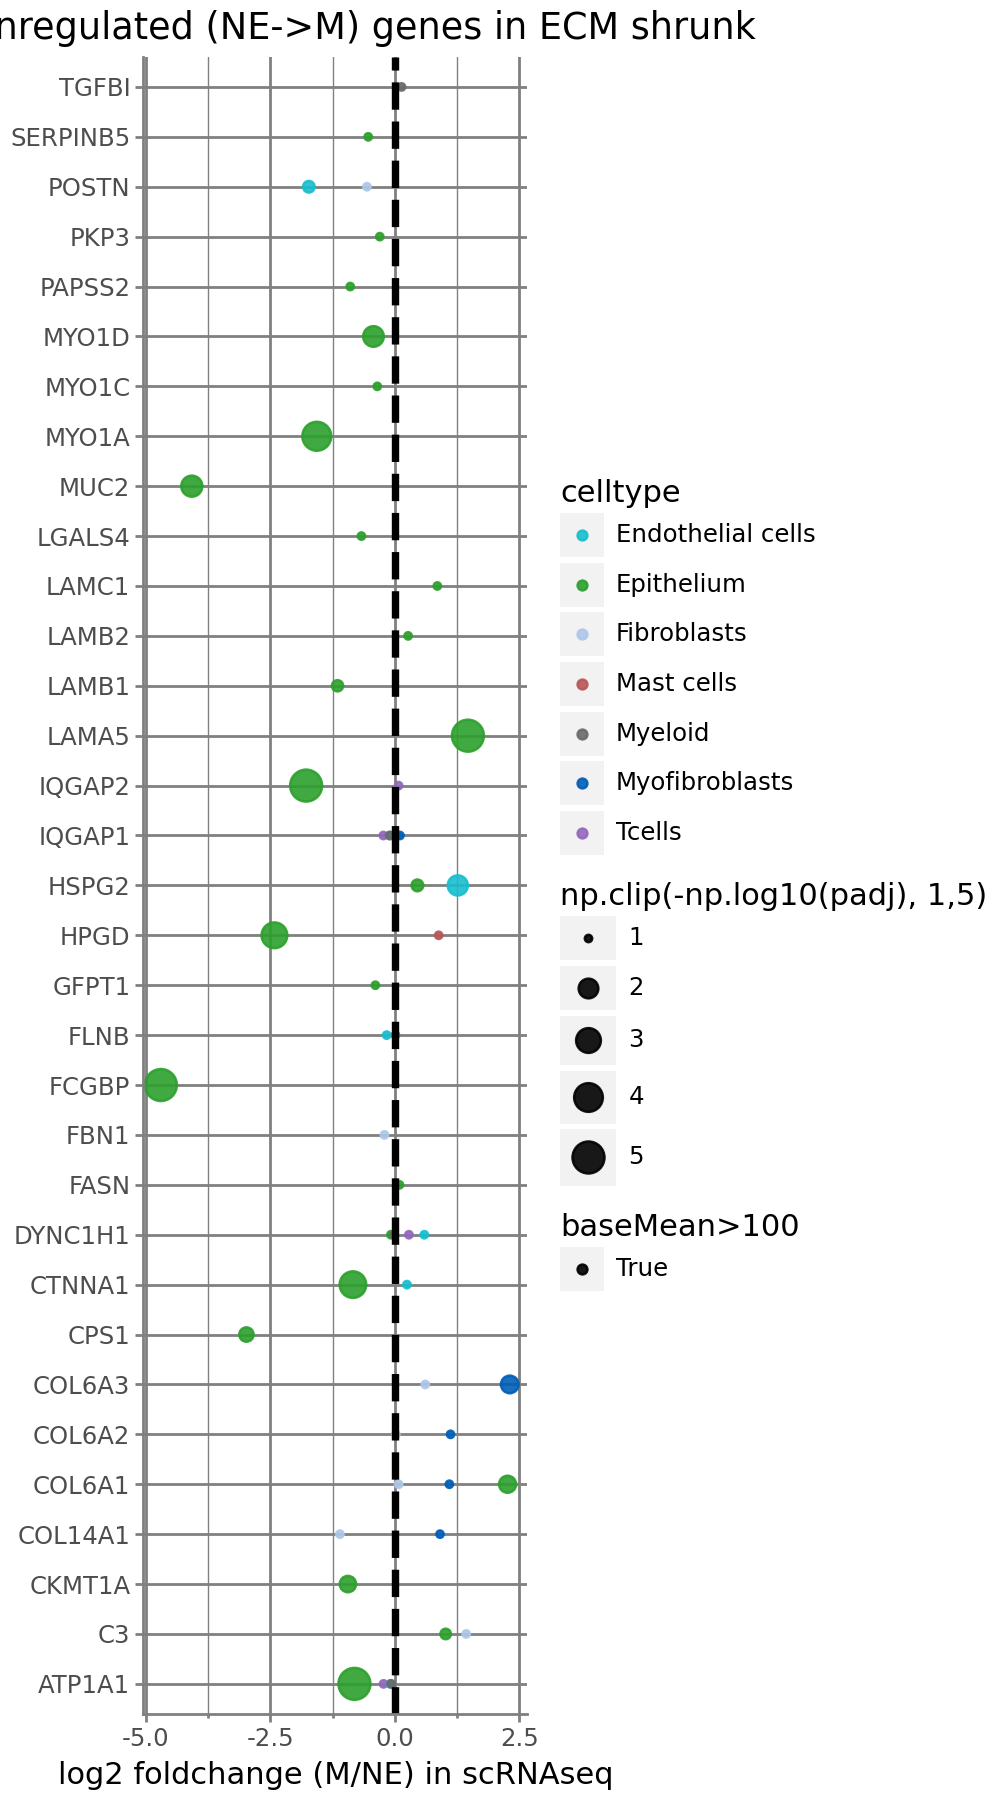

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_M_vs_T/ECM_DESeq_FC_per_celltype_down_patient_diag_unshrunk_baseMean.svg


In [40]:
p2 = the_plot_unshrunk(df_de_all.loc[[_ for _ in genes_down if _ in  df_de_all.index]].reset_index().query("baseMean>100")) + pn.labs(x='log2 foldchange (M/NE) in scRNAseq', title='Downregulated (NE->M) genes in ECM shrunk', y='')
p2.show()

p2.save(f'{plotfolder}/ECM_DESeq_FC_per_celltype_down_patient_diag_unshrunk_baseMean.svg')

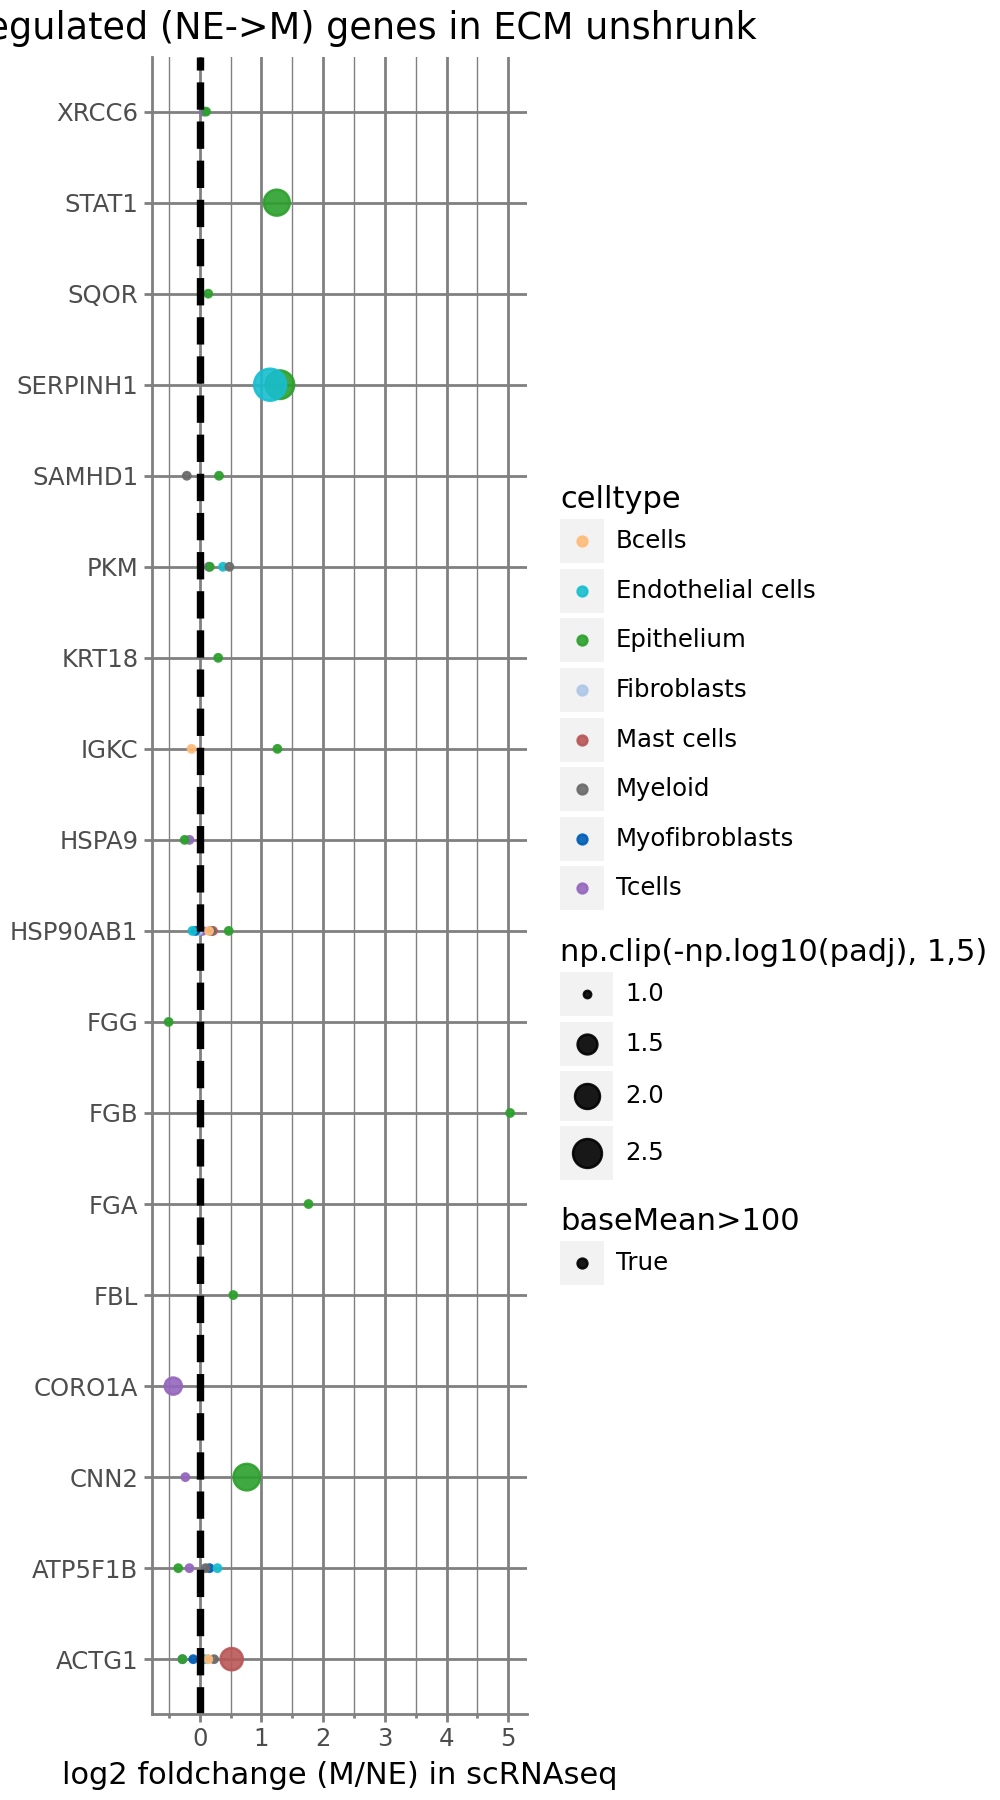

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_M_vs_T/ECM_DESeq_FC_per_celltype_up_patient_diag_unshrunk_baseMean.svg


In [41]:
p2 = the_plot_unshrunk(df_de_all.loc[[_ for _ in genes_up if _ in  df_de_all.index]].reset_index().query("baseMean>100")) + pn.labs(x='log2 foldchange (M/NE) in scRNAseq', title='Upregulated (NE->M) genes in ECM unshrunk', y='')
p2.show()
p2.save(f'{plotfolder}/ECM_DESeq_FC_per_celltype_up_patient_diag_unshrunk_baseMean.svg')